In [1]:
"""
Calculation of metric AP-SD (subword discrimination task) and AP-RW (reconstructed word)

Author: Amit Meghanani

Contact: ameghanani1@sheffield.ac.uk

"""
import argparse
# import wandb
import random
import sys
import os
import numpy as np
import pandas as pd
import torch
from collections import Counter
from os import path
sys.path.append(os.path.abspath(os.path.join('..')))
from utility_functions.factorization_dataloader import dataset_embedding
from utility_functions.factorisation_model import fact_net
from utility_functions.utils_function import average_precision, metric2
from ast import literal_eval
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def cal_precision(model, loader, device, class_to_idx, distance):
    sub_embeddings, sub_words, words, unique_id = [], [], [], []
    s1,s2,s3,e1,e2,e3 = [],[],[],[],[],[]
    model = model.eval()
    with torch.no_grad():
        for idx, (emb, tokens, _, word_name, sp_ch_id) in enumerate(loader):
            tokens = torch.from_numpy(np.vectorize(class_to_idx.get)(np.array(tokens)))
            emb, tokens = emb.to(device), tokens.to(device)
        
            emb1, emb2, emb3 = model(emb)[0:3]
            l1 = tokens[0, :]
            l2 = tokens[1, :]
            l3 = tokens[2, :]
            # x1 is the first sub-word of the words in batch, same for x2, x3
            sub_embeddings.append(emb1)
            sub_embeddings.append(emb2)
            sub_embeddings.append(emb3)
            
            sub_words.append(l1.cpu())
            sub_words.append(l2.cpu())
            sub_words.append(l3.cpu())
            unique_id.append(sp_ch_id*3)
            words.append(word_name*3)
            s1.append(l1)
            s2.append(l2)
            s3.append(l3)
            e1.append(emb1)
            e2.append(emb2)
            e3.append(emb3)

    words = np.concatenate(words)       
    sub_words = np.concatenate(sub_words)
    s1 = np.concatenate(s1)
    s2 = np.concatenate(s2)
    s3 = np.concatenate(s3)

    unique_id = np.concatenate(unique_id)
    u_sub_words = np.unique(sub_words)
    sub_word2id = {v: k for k, v in enumerate(u_sub_words)}
    ids = [sub_word2id[w] for w in sub_words]
    sub_embeddings, ids = torch.cat(sub_embeddings,0).detach().cpu(), np.array(ids)

    e1 = torch.cat(e1,0).to(torch.float16)
    e2 = torch.cat(e2,0).to(torch.float16)
    e3 = torch.cat(e3,0).to(torch.float16)
    return s1,s2,s3,e1,e2,e3,sub_embeddings, sub_words, unique_id, ids, words
    

In [3]:

torch.manual_seed(3112)
torch.cuda.manual_seed(3112)
torch.cuda.manual_seed_all(3112)
np.random.seed(3112)
random.seed(3112)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(3121)


In [4]:
input_dim=128
base_dir = '/home/amitmeghanani/H-drive'
metadata_file='fastdata/acw21am/private/hubert_features/embeddings'
model_loc='../checkpoints/model_factorisation/L2_True_HUBERT/fact_True_cpu_BEST.pt'
embedding_loc='fastdata/acw21am/private/hubert_features/embeddings'
batch_size=256
sub_embedding_dim=128
distance="cosine"
proj=True
norm=True
shuffle_pos=False

In [5]:


# Check whether the specified text/dataframe meta file exists or not
isExist = os.path.exists(os.path.join(base_dir, metadata_file))

if not isExist:
    print(metadata_file)
    print("provide the correct path for the metadata file")
    sys.exit(1)


# Check whether the specified output path exists or not
isExist = os.path.exists(model_loc)

# Create a new directory for output if it does not exist 
if not isExist:
    print(model_loc)
    print("provide the correct path for the model file")
    sys.exit(1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("available device:",device)

if device.type == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False


available device: cpu


In [6]:
if norm:
    print("using normalized word embeddings")
    train_data = dataset_embedding(
    metadata = os.path.join(base_dir, metadata_file, "train_emb.csv"),
    embedding_mat = os.path.join(base_dir, embedding_loc, "train_emb_norm.pt")
    )
    val_data = dataset_embedding(
    metadata = os.path.join(base_dir, metadata_file, "val_emb.csv"),
    embedding_mat=os.path.join(base_dir, embedding_loc, "val_emb_norm.pt")
    )
    test_data = dataset_embedding(
    metadata = os.path.join(base_dir, metadata_file, "test_emb.csv"),
    embedding_mat = os.path.join(base_dir, embedding_loc, "test_emb_norm.pt")
    )
else:
    print("using un normalized word embeddings")
    train_data = dataset_embedding(
    metadata = os.path.join(base_dir, metadata_file, "train_emb.csv"),
    embedding_mat = os.path.join(embedding_loc, "train_emb.pt")
    )
    val_data = dataset_embedding(
    metadata = os.path.join(base_dir, metadata_file, "val_emb.csv"),
    embedding_mat=os.path.join(embedding_loc, "val_emb.pt")
    )
    test_data = dataset_embedding(
    metadata = os.path.join(base_dir, metadata_file, "test_emb.csv"),
    embedding_mat = os.path.join(embedding_loc, "test_emb.pt")
    )



    print("length of training data:",len(train_data))
    print("length of validation data:",len(val_data))
    print("length of test data:",len(test_data))

using normalized word embeddings


In [7]:

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    drop_last = False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    worker_init_fn=seed_worker,
    generator=g
)
val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    drop_last = False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    worker_init_fn=seed_worker,
    generator=g
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    drop_last = False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    worker_init_fn=seed_worker,
    generator=g
)


In [8]:

# define the class to sub-word labelled dictionary

token_list = []
for _, (_, tokens, _, _, _) in enumerate(train_loader):
    token_list = token_list + tokens

out = [item for t in token_list for item in t]
dict_tokens = Counter(out)
print("total tokens:",len(dict_tokens))
classes = dict_tokens.keys()
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
num_classes = len(dict_tokens)

# Define the model
model = fact_net(input_dim, sub_embedding_dim, num_classes, proj)
model = model.to(device)       

checkpoint = torch.load(model_loc, map_location=torch.device(device))

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

total tokens: 152
loaded model with projection layer


fact_net(
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc11): Linear(in_features=512, out_features=512, bias=True)
  (fc111): Linear(in_features=512, out_features=128, bias=True)
  (fc1111): Linear(in_features=128, out_features=152, bias=True)
  (fc2): Linear(in_features=128, out_features=512, bias=True)
  (fc22): Linear(in_features=512, out_features=512, bias=True)
  (fc222): Linear(in_features=512, out_features=128, bias=True)
  (fc2222): Linear(in_features=128, out_features=152, bias=True)
  (fc3): Linear(in_features=128, out_features=512, bias=True)
  (fc33): Linear(in_features=512, out_features=512, bias=True)
  (fc333): Linear(in_features=512, out_features=128, bias=True)
  (fc3333): Linear(in_features=128, out_features=152, bias=True)
  (fc_projection): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [9]:
## AP-SD metric
print("calculating AP-SD.........")
s1,s2,s3,e1,e2,e3,sub_embeddings, _, _, ids, _ = cal_precision(model, test_loader, device, class_to_idx, distance)
# test_avg_precision,_ = average_precision(sub_embeddings.cpu(),ids, args.distance,show_plot=False)
# print("average precision on test set - AP-SD :", test_avg_precision)

test_avg_precision,_ = average_precision(e1.cpu(),s1, distance,show_plot=False)
print("average precision on test set - ABX1 :", test_avg_precision)

test_avg_precision,_ = average_precision(e2.cpu(),s2,distance,show_plot=False)
print("average precision on test set - ABX2  :", test_avg_precision)

# test_avg_precision,_ = abx(e2.cpu(),s2, s1,s3,args.distance,show_plot=False)
# print("average precision on test set - ABX2 with different context:", test_avg_precision)

test_avg_precision,_ = average_precision(e3.cpu(),s3, distance,show_plot=False)
print("average precision on test set - ABX3 :", test_avg_precision)

calculating AP-SD.........
average precision on test set - ABX1 : 0.9448622483599991
average precision on test set - ABX2  : 0.8882377653502612
average precision on test set - ABX3 : 0.9374126799243435


In [10]:

## AP-RW metric

print("calculating AP-RW.........")
print("extracting subword embedding for every position from the train set....")
s1,s2,s3,e1,e2,e3,_, sub_words, unique_id, ids, words = cal_precision(model, train_loader, device, class_to_idx, distance)

df_train_sub_metadata = pd.DataFrame()
df_train_sub_metadata["unique_id"] = unique_id
df_train_sub_metadata["words"] = words
df_train_sub_metadata["ids"] = ids
df_train_sub_metadata["sub_words"] = np.vectorize(idx_to_class.get)(sub_words)

df_train_sub_metadata_plus = pd.DataFrame()
df_train_sub_metadata_plus["s1"] = np.vectorize(idx_to_class.get)(s1)
df_train_sub_metadata_plus["s2"] = np.vectorize(idx_to_class.get)(s2)
df_train_sub_metadata_plus["s3"] = np.vectorize(idx_to_class.get)(s3)

if norm:
    df_test_emb = torch.load(os.path.join(base_dir, embedding_loc, "test_emb_norm.pt"))
    df_test_metadata = pd.read_csv(os.path.join(base_dir, metadata_file, "test_emb.csv"), converters={'tokenized': literal_eval})
else:
    df_test_emb = torch.load(os.path.join(base_dir, embedding_loc, "test_emb.pt"))
    df_test_metadata = pd.read_csv(os.path.join(base_dir, metadata_file, "test_emb.csv"), converters={'tokenized': literal_eval})


calculating AP-RW.........
extracting subword embedding for every position from the train set....


## Plot subword embeddings for test set

In [169]:
s1,s2,s3,e1,e2,e3,_, sub_words, unique_id, ids, words = cal_precision(model, test_loader, device, class_to_idx, distance)

df_test_sub_metadata = pd.DataFrame()
df_test_sub_metadata["unique_id"] = unique_id
df_test_sub_metadata["words"] = words
df_test_sub_metadata["ids"] = ids
df_test_sub_metadata["sub_words"] = np.vectorize(idx_to_class.get)(sub_words)

df_test_sub_metadata_plus = pd.DataFrame()
df_test_sub_metadata_plus["s1"] = np.vectorize(idx_to_class.get)(s1)
df_test_sub_metadata_plus["s2"] = np.vectorize(idx_to_class.get)(s2)
df_test_sub_metadata_plus["s3"] = np.vectorize(idx_to_class.get)(s3)


In [170]:
# convert s1 to original subword
s1 = np.vectorize(idx_to_class.get)(s1)

In [171]:
# take the 5 most frequent subwords and corresponding entries in e1
most_freq_subwords = Counter(s1).most_common(5)
most_freq_subwords = [i[0] for i in most_freq_subwords]
print("most frequent subwords:",most_freq_subwords)


most frequent subwords: ['s', 'b', 'c', 'p', 'f']


In [172]:
# take corresponding entries in e1 and create x and y for t-SNE
idx = [i for i, j in enumerate(s1) if j in most_freq_subwords]
e1 = e1[idx,:]
s1 = s1[idx]

In [180]:
s1.shape

(1610,)

/home/amitmeghanani/anaconda3/envs/local_awe/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitmeghanani/anaconda3/envs/local_awe/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


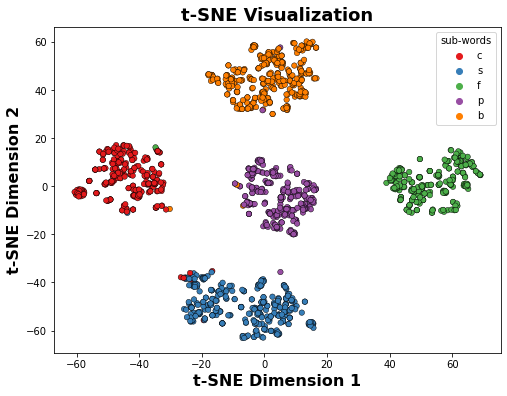

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

# Create a t-SNE plot using s1 and e1
tsne = TSNE(n_components=2, random_state=0)
e1_2d = tsne.fit_transform(e1.cpu())

# Create a DataFrame for the t-SNE plot
df = pd.DataFrame()
df["x"] = e1_2d[:, 0]
df["y"] = e1_2d[:, 1]
df["sub-words"] = s1

# Set up the plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference
sns.scatterplot(
    x="x", y="y",
    hue="sub-words",
    palette="Set1",
    data=df,
    edgecolor="k",  # Add black edgecolor to the markers
    s=30,  # Increase marker size for better visibility
    #alpha=0.8  # Increase transparency for better visibility of overlapping markers
)

# Customize plot elements
plt.title("t-SNE Visualization", fontsize=18, fontweight='bold')  # Increase title font size and set bold
plt.xlabel("t-SNE Dimension 1", fontsize=16, fontweight='bold')  # Increase x-axis label font size and set bold
plt.ylabel("t-SNE Dimension 2", fontsize=16, fontweight='bold')  # Increase y-axis label font size and set bold

# Save the plot in high quality
plt.savefig("aswe.png", dpi=300)  # Specify file name and dpi for high-resolution output

# Show the plot
plt.show()


/home/amitmeghanani/anaconda3/envs/local_awe/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitmeghanani/anaconda3/envs/local_awe/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

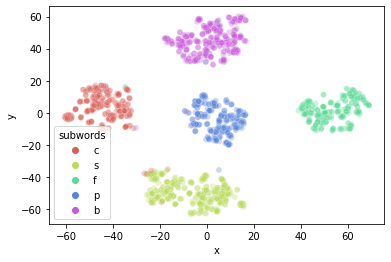

In [183]:
# create a  t-SNE plot usigg s1 and e1
tsne = TSNE(n_components=2, random_state=0)
e1_2d = tsne.fit_transform(e1.cpu())

# create a dataframe for the t-SNE plot
df = pd.DataFrame()
df["x"] = e1_2d[:,0]
df["y"] = e1_2d[:,1]
df["subwords"] = s1

# plot the t-SNE plot
sns.scatterplot(
    x="x", y="y",
    hue="subwords",
    palette=sns.color_palette("hls", len(most_freq_subwords)),
    data=df,
    legend="full",
    alpha=0.3
)




In [ ]:
# creat 

In [12]:
df_test_emb.shape

torch.Size([9778, 128])

In [13]:
df_test_metadata.head()

,unique_id,words,ids,tokenized
0,6534-71091-0048,GHEK,1241,"[g, he, k]"
1,1487-133273-0001,PLAYTHING,2302,"[pl, ay, thing]"
2,3257-169288-0025,GIRTH,1253,"[g, ir, th]"
3,5005-21379-0103,TOTAL,3075,"[to, t, al]"
4,3857-180923-0026,FIGHTS,1093,"[f, ight, s]"


In [98]:
# select 5  words from the test set with highest value counts
test_words = df_test_metadata["words"].value_counts().index[0:6]
test_words

Index(['HIMSELF', 'THEREFORE', 'EVERYONE', 'LONELY', 'VESSEL', 'CLOTHING'], dtype='object')

In [99]:
# find all the instances of the selected words in the test set and corresponding embedding and create a tsne plot of 4 clusters
x = []
y = []
for word in test_words:
    x.append(df_test_emb[df_test_metadata["words"]==word])
    # repeat y given number of times x is repeated
    y.append(np.repeat(word, len(df_test_emb[df_test_metadata["words"]==word])))

In [100]:
# create tsne plot for x and y
x = torch.cat(x,0)
y = np.concatenate(y)

/home/amitmeghanani/anaconda3/envs/local_awe/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitmeghanani/anaconda3/envs/local_awe/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


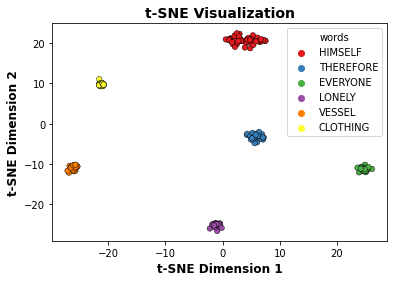

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

# Perform t-SNE embedding
x_embedded = TSNE(n_components=2).fit_transform(x)

# Create a DataFrame for plotting
df_tsne = pd.DataFrame()
df_tsne["x"] = x_embedded[:, 0]
df_tsne["y"] = x_embedded[:, 1]
df_tsne["words"] = y

# Set up the plot
plt.figure(figsize=(6, 4))  # Adjust the figure size as per your preference
sns.scatterplot(data=df_tsne, x="x", y="y", hue="words", palette="Set1", edgecolor="k", s=30)

# Customize plot elements
plt.title("t-SNE Visualization", fontsize=14, fontweight='bold')  # Increase title font size and set bold
plt.xlabel("t-SNE Dimension 1", fontsize=12, fontweight='bold')  # Increase x-axis label font size and set bold
plt.ylabel("t-SNE Dimension 2", fontsize=12, fontweight='bold')  # Increase y-axis label font size and set bold

# Save the plot in high quality
plt.savefig("tsne_plot.png", dpi=300)  # Specify file name and dpi for high-resolution output

# Show the plot
plt.show()


/home/amitmeghanani/anaconda3/envs/local_awe/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitmeghanani/anaconda3/envs/local_awe/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


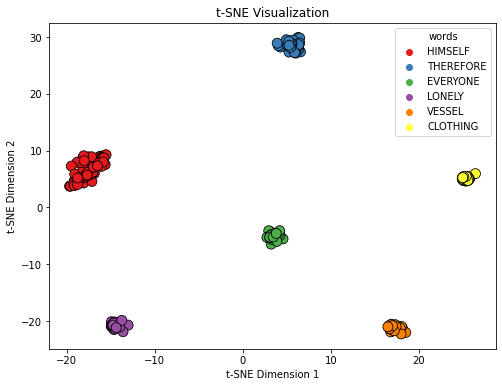

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

# Perform t-SNE embedding
x_embedded = TSNE(n_components=2).fit_transform(x)

# Create a DataFrame for plotting
df_tsne = pd.DataFrame()
df_tsne["x"] = x_embedded[:, 0]
df_tsne["y"] = x_embedded[:, 1]
df_tsne["words"] = y

# Set up the plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference
sns.scatterplot(data=df_tsne, x="x", y="y", hue="words", palette="Set1", edgecolor="k", s=100)

# Customize plot elements
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Show the plot
plt.show()


In [102]:

# x_embedded = TSNE(n_components=2).fit_transform(x)
# df_tsne = pd.DataFrame()
# df_tsne["x"] = x_embedded[:,0]
# df_tsne["y"] = x_embedded[:,1]
# df_tsne["words"] = y
# sns.scatterplot(data=df_tsne, x="x", y="y", hue="words", palette="deep")


In [ ]:
## calculate average sub-word embedding from training set for all three positions

list_sub_words1 = df_train_sub_metadata_plus['s1'].unique()
print("list of subwords in case of first subword")
sub_word_mat1 = np.zeros(shape=(len(list_sub_words1), sub_embedding_dim))
for i, sword in enumerate(list_sub_words1):
    index_sword = df_train_sub_metadata_plus[df_train_sub_metadata_plus["s1"]==sword].index
    sub_word_mat1[i] = torch.mean(e1[index_sword], 0).numpy() 

if norm:
    print("error alert")
    sub_word_mat1 = F.normalize(torch.from_numpy(sub_word_mat1),dim=1)
    print("checking norm is 1",torch.norm(sub_word_mat1[0]))
    sub_word_mat1 = sub_word_mat1.numpy()


sub_word_dict1 = dict(zip(list_sub_words1,sub_word_mat1))
print("total unique subwords in 1st position", len(list_sub_words1))
print(sub_word_mat1.shape)


list_sub_words2 = df_train_sub_metadata_plus['s2'].unique()
print("list of subwords in case of second subword")
sub_word_mat2 = np.zeros(shape=(len(list_sub_words2), sub_embedding_dim))
for i, sword in enumerate(list_sub_words2):
    index_sword = df_train_sub_metadata_plus[df_train_sub_metadata_plus["s2"]==sword].index
    sub_word_mat2[i] = torch.mean(e2[index_sword], 0).numpy() 

if norm:
    print("error alert")
    sub_word_mat2 = F.normalize(torch.from_numpy(sub_word_mat2))
    print("checking norm is 1",torch.norm(sub_word_mat2[0]))
    sub_word_mat2 = sub_word_mat2.numpy()
    
sub_word_dict2 = dict(zip(list_sub_words2,sub_word_mat2))
print("total unique subwords in second position", len(list_sub_words2))
print(sub_word_mat2.shape)

list_sub_words3 = df_train_sub_metadata_plus['s3'].unique()
print("list of subwords in case of third subword")
sub_word_mat3 = np.zeros(shape=(len(list_sub_words3), sub_embedding_dim))
for i, sword in enumerate(list_sub_words3):
    index_sword = df_train_sub_metadata_plus[df_train_sub_metadata_plus["s3"]==sword].index
    sub_word_mat3[i] = torch.mean(e3[index_sword], 0).numpy() 

if norm:
    print("error alert")
    sub_word_mat3 = F.normalize(torch.from_numpy(sub_word_mat3))
    print("checking norm is 1",torch.norm(sub_word_mat3[0]))
    sub_word_mat3 = sub_word_mat3.numpy()
    
sub_word_dict3 = dict(zip(list_sub_words3,sub_word_mat3))
print("total unique subwords in third position", len(list_sub_words3))
print(sub_word_mat3.shape)


unique_words = df_test_metadata["words"].unique()
print("total unique words in test set",len(unique_words))

artificial_words = np.zeros(shape=(len(unique_words), input_dim)) ## embedding dim is input_dim  here

In [ ]:
if shuffle_pos==False:
    flag = []
    for i, w in enumerate(unique_words):
        index = df_test_metadata[df_test_metadata["words"] == w].index[0]
        bpe_list = df_test_metadata.iloc[index,3]
        
        # check if the subwords are present in the training set or not
        if bpe_list[0] in list_sub_words1 and bpe_list[1] in list_sub_words2 and bpe_list[2] in list_sub_words3:
            sum_emb = sub_word_dict1[bpe_list[0]] + sub_word_dict2[bpe_list[1]] + sub_word_dict3[bpe_list[2]]
            flag.append(True)
        else:
            sum_emb = np.zeros((1,128))
            flag.append(False)

        if proj:
            sum_emb = torch.from_numpy(sum_emb)
            artificial_words[i] = torch.tanh(model.fc_projection(sum_emb.float())).detach().numpy()
        else:
            artificial_words[i] = sum_emb
    if norm:
        artificial_words = F.normalize(torch.from_numpy(artificial_words)).numpy()

    artificial_words = artificial_words[flag]
    unique_words = unique_words[flag]

    lista = unique_words
    listb = df_test_metadata["words"].values

    labels = []
    for i in lista:
        for j in listb:
            if i==j:
                labels.append(True)
            else:
                labels.append(False)
    ap_rw, _ = metric2(artificial_words, df_test_emb, np.array(labels), distance)

    print("Average precision for constructed words (AP-CW):", ap_rw)


else:
    flag = []
    for i, w in enumerate(unique_words):
        index = df_test_metadata[df_test_metadata["words"] == w].index[0]
        bpe_list = df_test_metadata.iloc[index,3]

        # if bpe_list[0] in list_sub_words3 and bpe_list[2] in list_sub_words1:
        #     sum_emb = sub_word_dict1[bpe_list[2]] + sub_word_dict2[bpe_list[1]] + sub_word_dict3[bpe_list[0]]
        if bpe_list[1] in list_sub_words3 and bpe_list[2] in list_sub_words2 and bpe_list[0] in list_sub_words1:
            sum_emb = sub_word_dict1[bpe_list[0]] + sub_word_dict3[bpe_list[1]] + sub_word_dict2[bpe_list[2]]
            flag.append(True)
        else: 
            sum_emb = np.zeros((1,128))
            flag.append(False)

        if proj:
            sum_emb = torch.from_numpy(sum_emb)
            artificial_words[i] = torch.tanh(model.fc_projection(sum_emb.float())).detach().numpy()
        else:
            artificial_words[i] = sum_emb

    if norm:
        artificial_words = F.normalize(torch.from_numpy(artificial_words)).numpy()

    artificial_words = artificial_words[flag]
    unique_words = unique_words[flag]

    lista = unique_words
    listb = df_test_metadata["words"].values

    labels = []
    for i in lista:
        for j in listb:
            if i==j:
                labels.append(True)
            else:
                labels.append(False)
    test_metric2, _ = metric2(artificial_words, df_test_emb, np.array(labels), distance)

    print("Average precision for reconstructed words (AP-RW) for swapped pos 2 and 3:", test_metric2)

## Nearest neighbour words

In [ ]:
df_train_metadata = pd.read_csv(os.path.join(base_dir, metadata_file, "train_emb.csv"), converters={'tokenized': literal_eval})
train_words = df_train_metadata["words"].values

In [ ]:
test_words = df_test_metadata["words"].values
# get the word present in test but not in train
test_words_not_in_train = np.setdiff1d(test_words, train_words)

In [ ]:
unique_words = test_words_not_in_train
print("total unique words in test set",len(unique_words))
artificial_words = np.zeros(shape=(len(unique_words), input_dim)) ## embedding dim is input_dim  here

In [ ]:
if shuffle_pos==False:
    flag = []
    for i, w in enumerate(unique_words):
        index = df_test_metadata[df_test_metadata["words"] == w].index[0]
        bpe_list = df_test_metadata.iloc[index,3]
        
        # check if the subwords are present in the training set or not
        if bpe_list[0] in list_sub_words1 and bpe_list[1] in list_sub_words2 and bpe_list[2] in list_sub_words3:
            sum_emb = sub_word_dict1[bpe_list[0]] + sub_word_dict2[bpe_list[1]] + sub_word_dict3[bpe_list[2]]
            flag.append(True)
        else:
            sum_emb = np.zeros((1,128))
            flag.append(False)

        if proj:
            sum_emb = torch.from_numpy(sum_emb)
            artificial_words[i] = torch.tanh(model.fc_projection(sum_emb.float())).detach().numpy()
        else:
            artificial_words[i] = sum_emb
    if norm:
        artificial_words = F.normalize(torch.from_numpy(artificial_words)).numpy()

    artificial_words = artificial_words[flag]
    unique_words = unique_words[flag]

    lista = unique_words
    listb = df_test_metadata["words"].values

    labels = []
    for i in lista:
        for j in listb:
            if i==j:
                labels.append(True)
            else:
                labels.append(False)
    ap_rw, _ = metric2(artificial_words, df_test_emb, np.array(labels), distance)

    print("Average precision for constructed words (AP-CW):", ap_rw)


else:
    flag = []
    for i, w in enumerate(unique_words):
        index = df_test_metadata[df_test_metadata["words"] == w].index[0]
        bpe_list = df_test_metadata.iloc[index,3]

        # if bpe_list[0] in list_sub_words3 and bpe_list[2] in list_sub_words1:
        #     sum_emb = sub_word_dict1[bpe_list[2]] + sub_word_dict2[bpe_list[1]] + sub_word_dict3[bpe_list[0]]
        if bpe_list[1] in list_sub_words3 and bpe_list[2] in list_sub_words2 and bpe_list[0] in list_sub_words1:
            sum_emb = sub_word_dict1[bpe_list[0]] + sub_word_dict3[bpe_list[1]] + sub_word_dict2[bpe_list[2]]
            flag.append(True)
        else: 
            sum_emb = np.zeros((1,128))
            flag.append(False)

        if proj:
            sum_emb = torch.from_numpy(sum_emb)
            artificial_words[i] = torch.tanh(model.fc_projection(sum_emb.float())).detach().numpy()
        else:
            artificial_words[i] = sum_emb

    if norm:
        artificial_words = F.normalize(torch.from_numpy(artificial_words)).numpy()

    artificial_words = artificial_words[flag]
    unique_words = unique_words[flag]

    lista = unique_words
    listb = df_test_metadata["words"].values

    labels = []
    for i in lista:
        for j in listb:
            if i==j:
                labels.append(True)
            else:
                labels.append(False)
    test_metric2, _ = metric2(artificial_words, df_test_emb, np.array(labels), distance)

    print("Average precision for reconstructed words (AP-RW) for swapped pos 2 and 3:", test_metric2)

In [ ]:
unique_words = ["REC_" + i for i in unique_words]

In [ ]:
# rn = [unique_words.index('REC_ATONEMENT'), unique_words.index('REC_THREES'),
#       unique_words.index('REC_STONY'), unique_words.index('REC_BASTARD')]
# rn = [unique_words.index(i) for i in ['REC_ALLISTER', 'REC_ANYTHING', 'REC_FLOG', 'REC_ROLLED']]
# rn = [unique_words.index(i) for i in ['REC_TYPE', 'REC_BRIBE', 'REC_CONTOUR', 'REC_COMMENTED']]
# rn = [unique_words.index(i) for i in ['REC_CONFEST', 'REC_FARGO', 'REC_CUNARD', 'REC_EXPEL']]
# rn = [unique_words.index(i) for i in ['REC_RASTA', 'REC_TEEM', 'REC_POPPO', 'REC_BEATER']]
# rn = [unique_words.index(i) for i in ['REC_WARDING', 'REC_BARDI', 'REC_EMMY', 'REC_MOWER']]
# rn = [unique_words.index(i) for i in ['REC_NEEDEST', 'REC_TAPPER', 'REC_ORTHERIS', 'REC_BOWIN']]
rn = [unique_words.index(i) for i in ['REC_VISED', 'REC_CASTER', 'REC_MENDES', 'REC_INDICES']]

In [ ]:
rn

In [ ]:
# rn = random.sample(range(0, len(unique_words)), 4)
# rn = [1013, 348, 318, 1690]
list_of_nn_words = []
list_of_nn_index = []
list_of_recon = []
b = df_test_emb.numpy()
test_words = df_test_metadata["words"].values
for i in rn:
    a = np.expand_dims(artificial_words[i], axis=0)
    dists = cdist(a, b, 'cosine').flatten()
    labels_nn = np.array(test_words)
    labels_nn = labels_nn[np.argsort(dists)][:3]
    list_of_nn_index.append(np.argsort(dists)[:3])
    list_of_nn_words.append(labels_nn)
    list_of_recon.append(unique_words[i])
list_of_nn_words = np.concatenate(list_of_nn_words)
list_of_nn_index = np.concatenate(list_of_nn_index)

In [ ]:
PLOT_RW = artificial_words[rn]
list_of_recon

In [ ]:
df_test_metadata.iloc[list_of_nn_index]

In [ ]:
PLOT_RW.shape

In [ ]:
PLOT_NN = df_test_emb.numpy()[list_of_nn_index]
list_of_nn_words

In [ ]:
'FARGO' in train_words

In [ ]:
'FARGO' in test_words

In [ ]:
'FARGO' in test_words_not_in_train

In [ ]:
X = np.concatenate([PLOT_RW, PLOT_NN])
words = np.concatenate([list_of_recon, list_of_nn_words])
X.shape

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

In [ ]:
tsne_df = pd.DataFrame({'X':X_embedded[:,0],
                        'Y':X_embedded[:,1],
                        'digit':words})
tsne_df.head()

In [ ]:
def petalplot(df): 
    
    def plotlabel(xvar, yvar, label):
        ax.text(xvar+0.002, yvar, label)
        
    fig = plt.figure(figsize=(10,10))
    ax = sns.scatterplot(x = 'X', y = 'Y', data=df)

    # The magic starts here:
    df.apply(lambda x: plotlabel(x['X'],  x['Y'], x['digit']), axis=1)

#     plt.title('Example Plot')
#     plt.xlabel('Sepal Length')
#     plt.ylabel('Sepal Width')
    
petalplot(tsne_df)